### Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer
import mysql.connector
from mysql.connector import Error
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Masking, Reshape, Layer, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as be
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta
from keras.layers import BatchNormalization
from keras.regularizers import l2
import matplotlib.pyplot as plt

### Updated Database pull to avoid duplicate columns, adding risk-free rate and converting risk free rate to yearly rate

In [ ]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# MySQL database connection function
def connect_to_database():
    try:
        # Establishing connection to the database
        connection = mysql.connector.connect(
            host='crypto-matter.c5eq66ogk1mf.eu-central-1.rds.amazonaws.com',
            database='Crypto',
            user='Jing',  # Replace with your actual first name
            password='Crypto12!'
        )

        if connection.is_connected():
            db_info = connection.get_server_info()
            print("Connected to MySQL database, MySQL Server version: ", db_info)
            return connection

    except Error as e:
        print("Error while connecting to MySQL", e)
        return None

# Function to query merged data from crypto_lending_borrowing and crypto_price tables
def query_merged_crypto_data(connection):
    query = """
    SELECT clb.lending_rate, clb.borrowing_rate, clb.utilization_rate, clb.stable_borrow_rate,
    cp.*, usb.yield
    FROM crypto_lending_borrowing clb
    JOIN crypto_price cp 
        ON clb.crypto_symbol = cp.crypto_symbol
        AND clb.date = cp.date
    LEFT JOIN US_Bond_Yield usb
        ON clb.date = usb.date
    WHERE UPPER(clb.crypto_symbol) IN ('1INCHUSDT', 'BALUSDT', 'BATUSDT', 'CRVUSDT', 'ENJUSDT', 'ENSUSDT', 'KNCUSDT', 'LINKUSDT', 'MANAUSDT', 'MKRUSDT', 'RENUSDT', 'SNXUSDT', 'UNIUSDT', 'WBTCUSDT', 'YFIUSDT', 'ZRXUSDT')
    """
    cursor = connection.cursor()

    try:
        # Execute the query
        cursor.execute(query)

        # Fetch all results
        results = cursor.fetchall()

        # Get column names from cursor description
        columns = [desc[0] for desc in cursor.description]

        # Convert results to a Pandas DataFrame
        df = pd.DataFrame(results, columns=columns)

        return df

    except Error as e:
        print(f"Error: {e}")
        return None
    finally:
        cursor.close()

# Function to close the database connection
def query_quit(connection):
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")


connection = connect_to_database()

if connection:
    # Query merged data
    merged_df = query_merged_crypto_data(connection)
    # converting US bond yield from hourly to yearly under continous compounding assumptions
    merged_df['yield'] = np.exp(merged_df['yield']*365*24)-1

    if merged_df is not None and not merged_df.empty:
        # Display first few rows of the DataFrame
        print("\nMerged DataFrame:")
        print(merged_df.head())
    else:
        print("\nNo data found after merging.")

    # Close the connection
    query_quit(connection)

### Code block to get embeddings + pca for dim reduction

In [ ]:
def create_llm_embeddings(dataframe, col, n_components=10):
    model = SentenceTransformer('all-MiniLM-L6-v2')

    unique_values = dataframe[col].unique()
    
    # Get embeddings for the unique values
    embeddings = model.encode(unique_values, show_progress_bar=False)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create a DataFrame to hold the reduced embeddings
    reduced_embeddings_df = pd.DataFrame(reduced_embeddings, columns=[f'{col}_embedding_{i+1}' for i in range(n_components)])

    reduced_embeddings_df[col] = unique_values

    dataframe = dataframe.merge(reduced_embeddings_df, on=col, how='left')

    return dataframe

merged_df_emb = create_llm_embeddings(merged_df, "crypto_symbol", n_components=15)


### Code block for creating cyclical encodings

In [ ]:
def create_cyclical_encodings(df, date_col):
    
    days_in_month_dict = {
    1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
    7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

    df["Year"] = df[date_col].dt.year
    df["Month"] = df[date_col].dt.month
    df["Day"] = df[date_col].dt.day
    df["Hour"] = df[date_col].dt.hour
    df["DayofWeek"] = df[date_col].dt.dayofweek

    # Vectorized leap year handling and days in month calculation
    leap_year_mask = (df['Year'] % 4 == 0) & ((df['Year'] % 100 != 0) | (df['Year'] % 400 == 0))
    df['days_in_month'] = df['Month'].map(days_in_month_dict)
    
    # Adjust February for leap years
    df.loc[leap_year_mask & (df['Month'] == 2), 'days_in_month'] = 29

    df["Month_Sine"] = np.sin(2* np.pi * df["Month"] / 12)
    df["Month_Cosine"] = np.cos(2* np.pi * df["Month"] / 12)
    
    df["Day_Sine"] = np.sin(2* np.pi * df["Day"] / df['days_in_month'])
    df["Day_Cosine"] = np.cos(2* np.pi * df["Day"] / df['days_in_month'])
    
    df["Hour_Sine"] = np.sin(2* np.pi * df["Hour"] / 24)
    df["Hour_Cosine"] = np.cos(2* np.pi * df["Hour"] / 24)
    
    df["DayofWeek_Sine"] = np.sin(2* np.pi * df["DayofWeek"] / 7)
    df["DayofWeek_Cosine"] = np.cos(2* np.pi * df["DayofWeek"] / 7)

    df.drop(columns=["Month", "Day", "days_in_month", "Hour", "DayofWeek", "Year"], inplace=True)

    return df

merged_df_emb = create_cyclical_encodings(merged_df_emb, "date")

### Base Architecture

Tunable Parameters:

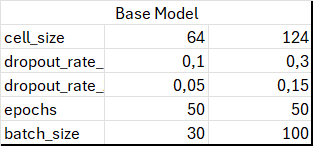

In [ ]:
def LSTM_base_model(X_train, Y_class_train, X_valid, Y_class_valid,X_test,Y_class_test,
                    cell_size=80, dropout_rate_1=0.3, dropout_rate_2=0.1, 
                    epochs=50,batch_size=30):
    
    be.clear_session()
    
    n_classes = 3

    cell_size_1 = cell_size
    cell_size_2 = cell_size_1//2
    
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    Masking_layer = Masking(mask_value=-50)(inputs)
    Lstm_layer_1 = LSTM(cell_size_1, return_sequences=True, stateful=False, use_cudnn=False)(Masking_layer)
    Batch_norm_1 = BatchNormalization()(Lstm_layer_1)
    Dropout_layer_1 = Dropout(dropout_rate_1)(Batch_norm_1)
    Lstm_layer_2 = LSTM(cell_size_2, return_sequences=False, stateful=False, use_cudnn=False)(Dropout_layer_1)  # just halved
    Batch_norm_2 = BatchNormalization()(Lstm_layer_2)
    Drouput_layer_2 = Dropout(dropout_rate_2)(Batch_norm_2)
    predictions = Dense(Y_class_train.shape[1]*Y_class_train.shape[2]*n_classes, activation='softmax')(Drouput_layer_2)
    predictions_reshaped = Reshape((Y_class_train.shape[1], Y_class_train.shape[2], n_classes),name="class")(predictions)
    LSTM_base = Model(inputs=inputs, outputs=predictions_reshaped)
    
    # we will keep this as a standardized learning rate optimizer across all models
    optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7)      # Default , to prevent division by zero)
    
    def sparse_crossentropy_masked(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        mask = tf.not_equal(y_true, -50)
        y_true_masked = tf.boolean_mask(y_true, mask)
        y_pred_masked = tf.boolean_mask(y_pred, mask)
        loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y_true_masked, y_pred_masked)
        return tf.reduce_mean(loss)
    
    LSTM_base.compile(
        optimizer=optimizer,
        loss=sparse_crossentropy_masked,
        metrics=['accuracy'])
    
    LSTM_base.summary()
    
    history = LSTM_base.fit(x=X_train, y=Y_class_train,
                    validation_data=(X_valid, Y_class_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=False)
    
    # Extract the specific loss keys for class_predictions
    class_train_loss_key = 'class_loss'
    class_val_loss_key = 'val_class_loss'

    # Plot the class_predictions losses
    plt.plot(history.history[class_train_loss_key], label='Class Train Loss')
    plt.plot(history.history[class_val_loss_key], label='Class Validation Loss')

    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses Class Prediction')
    plt.show()

    y_pred = LSTM_base.predict(X_test)

    y_pred = np.argmax(y_pred, axis=-1)

    def classification_metrics(y_true, y_pred):
        valid_indices = y_true != -50
        # Apply the mask to y_true and y_pred
        y_true_filtered = y_true[valid_indices]
        y_pred_filtered = y_pred[valid_indices]
    
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
        
        # Visualization of the confusion matrix using Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        recall = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        f1 = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        
        # Printing classification metrics
        print("Classification Metrics:")
        print("Accuracy: {:.2f}".format(accuracy))
        print("Precision: {:.2f}".format(precision))
        print("Recall: {:.2f}".format(recall))
        print("F1 Score: {:.2f}".format(f1))
    
        # Detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true_filtered, y_pred_filtered, target_names=['0', '1', '2']))
        return accuracy, precision, recall, f1
    
    accuracy, precision, recall, f1 = classification_metrics(Y_class_test,y_pred)
    
    return LSTM_base

# Example usage
LSTM_base = LSTM_base_model(X_train, Y_class_train, X_valid, Y_class_valid,X_test,Y_class_test,
                    cell_size=80, dropout_rate_1=0.3, dropout_rate_2=0.1, 
                    epochs=20,batch_size=50)


### VAE Architecture

Extra tunable hyperparamters:

laten dim for VAE: The input is a divisor for cell size 2, cell size 2 is cell size 1 divided by 2, so maybe try 6,3,2. That would mean for cell size 124, latent dim would be in those 3 cases (4): 10,21,32. The other one is KL loss, I would suggest 0.01, 0.05, 0.1 and 0.2, and leave weight for entropy loss unchanged.

Or for ease like this:

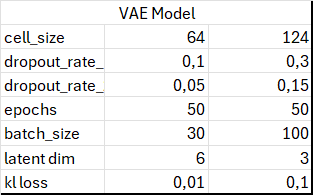


In [ ]:
def LSTM_autoencoder_rates_and_class(X_train, Y_class_train, Y_train, X_valid, Y_class_valid,Y_valid,X_test, Y_class_test,
                    cell_size=80, dropout_rate_1=0.3,latent_dim=6,
                    epochs=50,batch_size=30, loss_weights=[1,0.1]):
    
    be.clear_session()
    n_classes = 3

    cell_size_1 = cell_size
    cell_size_2 = cell_size_1//2
    latent_dim = cell_size_2/latent_dim
    
    class KLDivergenceLayer(Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            self.add_loss(kl_loss)  # Add the KL loss to the layer's loss terms
            return kl_loss
        
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    Masking_layer = Masking(mask_value=-50)(inputs)
    Lstm_layer_1 = LSTM(cell_size_1,activation='tanh', return_sequences=True, stateful=False, use_cudnn=False)(Masking_layer)
    Batch_norm_1 = BatchNormalization()(Lstm_layer_1)
    Dropout_layer_1 = Dropout(dropout_rate_1)(Batch_norm_1)
    Lstm_layer_2 = LSTM(cell_size_2,activation='tanh', return_sequences=False, stateful=False, use_cudnn=False)(Dropout_layer_1)  # just halved
    Batch_norm_2 = BatchNormalization()(Lstm_layer_2)
    
    # Latent space representation (mean and log variance)
    z_mean = Dense(latent_dim)(Batch_norm_2)
    z_log_var = Dense(latent_dim)(Batch_norm_2)
    
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = be.random_normal(shape=(be.shape(z_mean)[0], latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    
    decoder_hidden = Dense(cell_size_2, activation='relu')(z)
    reshaped_decoder_input = Reshape((1, cell_size_2))(decoder_hidden)
    Lstm_decoder_1 = LSTM(cell_size_2, return_sequences=True, use_cudnn=False, activation='tanh')(reshaped_decoder_input)
    Batch_norm_3 = BatchNormalization()(Lstm_decoder_1)
    Lstm_decoder_2 = LSTM(cell_size_1, return_sequences=True, use_cudnn=False, activation='tanh')(Batch_norm_3)
    Batch_norm_4 = BatchNormalization()(Lstm_decoder_2)
    Dropout_layer_2 = Dropout(dropout_rate_1)(Batch_norm_4)
    
    class_predictions = Dense(Y_class_train.shape[1]*Y_class_train.shape[2]*n_classes, activation='softmax')(Dropout_layer_2)
    class_predictions_reshaped = Reshape((Y_class_train.shape[1], Y_class_train.shape[2], n_classes),name="class")(class_predictions)

    kl_loss_layer = KLDivergenceLayer(name='kl_loss')([z_mean, z_log_var])

    LSTM_base_decoder = Model(inputs=inputs,outputs=[class_predictions_reshaped, kl_loss_layer])
    # we will keep this as a standardized learning rate optimizer across all models
    optimizer = Adadelta(
    learning_rate=1.0,
    rho=0.8,
    epsilon=1e-7)
    
    def sparse_crossentropy_masked(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        mask = tf.not_equal(y_true, -50)
        y_true_masked = tf.boolean_mask(y_true, mask)
        y_pred_masked = tf.boolean_mask(y_pred, mask)
        loss = tf.compat.v1.losses.sparse_softmax_cross_entropy(y_true_masked, y_pred_masked)
        return tf.reduce_mean(loss)
    
    LSTM_base_decoder.compile(
        optimizer=optimizer,
        loss=[sparse_crossentropy_masked, lambda y_true, y_pred: tf.reduce_mean(y_pred)],
        loss_weights = loss_weights)
    
    LSTM_base_decoder.summary()
    
    history = LSTM_base_decoder.fit(X_train, 
               [Y_class_train, np.zeros_like(Y_train)],
               validation_data=(X_valid, [Y_class_valid, np.zeros_like(Y_valid)]),
                                epochs=epochs,
                                batch_size=batch_size,
                                shuffle=False)
    
    # Extract the specific loss keys for class_predictions
    class_train_loss_key = 'class_loss'
    class_val_loss_key = 'val_class_loss'

    # Plot the class_predictions losses
    plt.plot(history.history[class_train_loss_key], label='Class Train Loss')
    plt.plot(history.history[class_val_loss_key], label='Class Validation Loss')

    # Add labels and legend
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Losses Class Prediction')
    plt.show()

    y_pred, y_placeholder = LSTM_base_decoder.predict(X_test)

    y_pred = np.argmax(y_pred, axis=-1)

    def classification_metrics(y_true, y_pred):
        valid_indices = y_true != -50
        # Apply the mask to y_true and y_pred
        y_true_filtered = y_true[valid_indices]
        y_pred_filtered = y_pred[valid_indices]
    
        # Calculate the confusion matrix
        conf_matrix = confusion_matrix(y_true_filtered, y_pred_filtered)
        
        # Visualization of the confusion matrix using Seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Calculate metrics
        accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
        precision = precision_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        recall = recall_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        f1 = f1_score(y_true_filtered, y_pred_filtered, average='macro', zero_division=0)
        
        # Printing classification metrics
        print("Classification Metrics:")
        print("Accuracy: {:.2f}".format(accuracy))
        print("Precision: {:.2f}".format(precision))
        print("Recall: {:.2f}".format(recall))
        print("F1 Score: {:.2f}".format(f1))
    
        # Detailed classification report
        print("\nDetailed Classification Report:")
        print(classification_report(y_true_filtered, y_pred_filtered, target_names=['0', '1', '2']))
        return accuracy, precision, recall, f1
    
    accuracy, precision, recall, f1 = classification_metrics(Y_class_test,y_pred)
    
    return LSTM_base_decoder

LSTM_base_decoder = LSTM_autoencoder_rates_and_class(X_train, Y_class_train, X_valid, Y_class_valid,Y_valid,X_test, Y_class_test,
                    cell_size=80, dropout_rate_1=0.3,latent_dim=10,l2_strength=0.1,
                    epochs=20,batch_size=50)
